In [475]:
import pandas as pd

from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D,Conv3D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Dropout
from keras.layers.core import Dense,Reshape
from keras.layers import Flatten
from keras.layers import Input
from keras.models import Model

from sklearn.model_selection import train_test_split
from keras.layers.core import Dense
from keras.models import Model
from keras.optimizers import Adam
from keras.layers import concatenate
import keras.backend as K
import keras.losses

import tensorflow as tf

import numpy as np
import argparse
import locale
import os
import datetime

import os
import random

import matplotlib.pyplot as plt

In [379]:
from preprocessing import prepare_stromfluesse,prepare_strompreise,prepare_konsum_ger,enrich_daily_information

---

In [392]:
# Parameter for later testing
# These days should not be seen by the model beforehand
test_number_days = 10

In [393]:
df_stromfluesse = prepare_stromfluesse("data/Stromfluss//")
df_price = prepare_strompreise("data/Strompreise/")
df_consumption = prepare_konsum_ger("data/Stromverbrauch_real/")

Import File: DE_Physikalischer_Stromfluss_201506010000_201706012359_1.csv 
Import File: DE_Physikalischer_Stromfluss_201706020000_201906022359_1.csv 
Import File: DE_Großhandelspreise_201706010000_201906012359_1.csv 
Import File: DE_Großhandelspreise_201506010000_201706012359_1.csv 
Import File: DE_Realisierter Stromverbrauch_201506010000_201706012345_1.csv 
Import File: DE_Realisierter Stromverbrauch_201706010000_201906012345_1.csv 


In [394]:
df_daily_information = enrich_daily_information(df_price,df_consumption)

In [395]:
df = df_stromfluesse.merge(df_daily_information,on="Tag")

In [396]:
error_scaling = (np.abs(df.loc[:,'NL':'PL'].sum(axis=0)) / np.abs(df.loc[:,'NL':'PL'].sum(axis=0)).sum()).values

In [397]:
"""for col in df.loc[:,'NL':'PL'].columns:
    df['same_time_1_week_'+col] = df[col].shift(24)
    df['same_time_2_week_'+col] = df[col].shift(24*2)
    df['same_time_3_week_'+col] = df[col].shift(24*3)
    df['same_time_4_week_'+col] = df[col].shift(24*4)

    df['last_day_sum_'+col] = df[col].shift(24).rolling(24).sum()
    
df.dropna(inplace=True)"""

"for col in df.loc[:,'NL':'PL'].columns:\n    df['same_time_1_week_'+col] = df[col].shift(24)\n    df['same_time_2_week_'+col] = df[col].shift(24*2)\n    df['same_time_3_week_'+col] = df[col].shift(24*3)\n    df['same_time_4_week_'+col] = df[col].shift(24*4)\n\n    df['last_day_sum_'+col] = df[col].shift(24).rolling(24).sum()\n    \ndf.dropna(inplace=True)"

# Data

In [398]:
df_prev_day_info = df.loc[:,'prev_day_consumption_ger'::]
df_prev_day_info.drop_duplicates(inplace=True)
df_prev_day_info['Tag'] = df['Tag']

df['Tag'] = pd.to_datetime(df['Tag'])
df_prev_day_info['Tag'] = pd.to_datetime(df_prev_day_info['Tag'])


In [399]:
df_prev_day_info.head()

,prev_day_consumption_ger,prev_day_price_deutschland/luxemburg,prev_day_price_dänemark 1,prev_day_price_dänemark 2,prev_day_price_frankreich,prev_day_price_italien (nord),prev_day_price_niederlande,prev_day_price_polen,prev_day_price_schweden 4,prev_day_price_schweiz,...,February,January,July,June,March,May,November,October,September,Tag
0,1284069.00,44.390017,20.788750,30.169583,30.997500,49.521667,42.491250,39.270939,30.169583,32.077083,...,0,0,0,1,0,0,0,0,0,2015-06-02
24,1365352.75,44.390017,16.130417,16.762500,24.302083,43.613333,33.039583,40.454272,16.762500,24.202500,...,0,0,0,1,0,0,0,0,0,2015-06-03
48,1339142.50,44.390017,15.313750,15.353333,30.330000,52.009167,37.045833,40.272606,15.353333,26.726667,...,0,0,0,1,0,0,0,0,0,2015-06-04
72,1104016.75,44.390017,22.298750,23.852917,31.705833,54.611667,46.650417,34.739724,23.462917,29.455833,...,0,0,0,1,0,0,0,0,0,2015-06-05
96,1212480.00,44.390017,17.689583,21.050833,39.059583,51.943333,43.321250,43.065957,21.050833,29.855000,...,0,0,0,1,0,0,0,0,0,2015-06-06


In [400]:
df_master = pd.DataFrame(index=np.arange(0,df.Tag.nunique()))
df_master['Tag'] = None
df_master['NX_per_country'] = None

In [402]:
ind = 0
for tag,group in df.groupby('Tag'):
    if len(group)==24:
        df_master.loc[ind,'Tag'] =  tag
        df_master.loc[ind,'NX_per_country'] =  group.loc[:,'NL':'PL'].values
    else:
        df_master.loc[ind,'NX_per_country'] = df_master.loc[ind-1,'NX_per_country'] 
        df_master.loc[ind,'Tag'] = df_master.loc[ind-1,'Tag'] 
        print("Tag weniger als 24 EInträge:{} {}".format(tag,len((group))))
    ind +=1

Tag weniger als 24 EInträge:2015-10-25 00:00:00 25
Tag weniger als 24 EInträge:2016-03-27 00:00:00 23
Tag weniger als 24 EInträge:2016-10-30 00:00:00 25
Tag weniger als 24 EInträge:2017-03-26 00:00:00 23
Tag weniger als 24 EInträge:2017-10-29 00:00:00 25
Tag weniger als 24 EInträge:2018-03-25 00:00:00 23
Tag weniger als 24 EInträge:2018-10-28 00:00:00 25
Tag weniger als 24 EInträge:2019-03-31 00:00:00 23


In [403]:
rolling_days = 14
for day in np.arange(1,rolling_days):
    name = 'NX_per_country_shifted_' + str(day)
    df_master[name] = df_master['NX_per_country'].shift(day)

df_master.dropna(inplace=True)

df_master['NX_per_country_aggregated'] = df_master.iloc[:,1::].apply(lambda row: np.concatenate(row), axis=1)

In [404]:
df_master['NX_per_country_shifted'] = df_master['NX_per_country_aggregated'].shift(1)
df_master.dropna(inplace=True)

df_master = df_master[['Tag','NX_per_country','NX_per_country_shifted']]

In [405]:
print(df_master.NX_per_country.iloc[0].shape)
print(df_master.NX_per_country_shifted.iloc[0].shape)
df_master.head()

(24, 9)
(336, 9)


,Tag,NX_per_country,NX_per_country_shifted
14,2015-06-16 00:00:00,"[[3614.0, -334.0, -1651.0, 101.0, 0.0, -192.0,...","[[3999.0, -700.0, -1123.0, -571.0, 0.0, -16.0,..."
15,2015-06-17 00:00:00,"[[3092.0, -135.0, -1688.0, -125.0, 0.0, -262.0...","[[3614.0, -334.0, -1651.0, 101.0, 0.0, -192.0,..."
16,2015-06-18 00:00:00,"[[4453.0, 414.0, -739.0, 117.0, 0.0, -115.0, 6...","[[3092.0, -135.0, -1688.0, -125.0, 0.0, -262.0..."
17,2015-06-19 00:00:00,"[[3733.0, 582.0, -594.0, 265.0, 0.0, 1.0, 1059...","[[4453.0, 414.0, -739.0, 117.0, 0.0, -115.0, 6..."
18,2015-06-20 00:00:00,"[[4154.0, -656.0, -1110.0, -318.0, 0.0, -181.0...","[[3733.0, 582.0, -594.0, 265.0, 0.0, 1.0, 1059..."


----

In [406]:
df_master['Tag'] = pd.to_datetime(df_master['Tag'])
df_master = df_master.merge(df_prev_day_info,on='Tag')

In [407]:
df_test = df_master.iloc[-1 * test_number_days::]
df_master = df_master.drop(df_master.iloc[-1 * test_number_days::].index)

In [408]:
df_master.head()

,Tag,NX_per_country,NX_per_country_shifted,prev_day_consumption_ger,prev_day_price_deutschland/luxemburg,prev_day_price_dänemark 1,prev_day_price_dänemark 2,prev_day_price_frankreich,prev_day_price_italien (nord),prev_day_price_niederlande,...,December,February,January,July,June,March,May,November,October,September
0,2015-06-16,"[[3614.0, -334.0, -1651.0, 101.0, 0.0, -192.0,...","[[3999.0, -700.0, -1123.0, -571.0, 0.0, -16.0,...",1282062.00,44.390017,16.734583,19.708750,34.933750,49.637917,39.079583,...,0,0,0,0,1,0,0,0,0,0
1,2015-06-17,"[[3092.0, -135.0, -1688.0, -125.0, 0.0, -262.0...","[[3614.0, -334.0, -1651.0, 101.0, 0.0, -192.0,...",1317198.00,44.390017,24.702500,31.787500,38.936667,53.107917,42.182500,...,0,0,0,0,1,0,0,0,0,0
2,2015-06-18,"[[4453.0, 414.0, -739.0, 117.0, 0.0, -115.0, 6...","[[3092.0, -135.0, -1688.0, -125.0, 0.0, -262.0...",1327201.75,44.390017,17.152083,18.956250,31.436667,54.573750,39.245833,...,0,0,0,0,1,0,0,0,0,0
3,2015-06-19,"[[3733.0, 582.0, -594.0, 265.0, 0.0, 1.0, 1059...","[[4453.0, 414.0, -739.0, 117.0, 0.0, -115.0, 6...",1344718.00,44.390017,11.081250,11.661667,36.921667,45.903750,41.537917,...,0,0,0,0,1,0,0,0,0,0
4,2015-06-20,"[[4154.0, -656.0, -1110.0, -318.0, 0.0, -181.0...","[[3733.0, 582.0, -594.0, 265.0, 0.0, 1.0, 1059...",1328946.50,44.390017,10.502500,10.502500,35.932500,45.857083,41.777083,...,0,0,0,0,1,0,0,0,0,0


---

# Models

In [720]:
def create_mlp(dim,layers):
    # define our MLP network
    model = Sequential()
    model.add(Dense(layers[0], input_dim=dim, activation="relu"))
    model.add(Dense(layers[1], activation="relu"))

    return model

In [721]:
def create_cnn(width, height,kernels,dropout_rate ):
    # initialize the input shape and channel dimension, assuming
    # TensorFlow/channels-last ordering
    depth=1
    inputShape = (height, width, depth) #channel-last (batch, rows, cols, channels)
    
    # define the model input
    inputs = Input(shape=inputShape)

    x = inputs
    
    x = Conv2D(kernels[0],kernel_size=(4,1),strides=1, padding="same")(x)
    x = Activation("relu")(x)
    # Output (batch, new_rows, new_cols, filters)    
    x = Dropout(dropout_rate)(x)
    # Output (batch, new_rows, new_cols, filters)
    # Input (batch, rows, cols, channels)
    x = Conv2D(1,kernel_size=(1,1),strides=1, padding="same")(x)
    x = Activation("relu")(x)
    # Output (batch, new_rows, new_cols, filters=1) 

    
    """y = inputs
    y = Conv2D(kernels[0],
               kernel_size=(24,1),
               strides=(24,1),
               kernel_initializer=kernel_init)(y)
    y = Activation("relu")(y)
    Y = Dropout(dropout_rate)(y)
    y = Conv2D(1,kernel_size=(1,1),strides=1, padding="same")(y)
    y = Activation("relu")(y)
    
    # flatten the volume, then FC => RELU => BN => DROPOUT
    y = Flatten()(y)"""
    
    x = Flatten()(x)

    #combinedOutput = concatenate([x, y])

    # construct the CNN
    model = Model(inputs, x)

    # return the CNN
    return model

In [722]:
def kernel_init(shape,dtype=tf.float64, partition_info=None):
    print("Kernel shape:{} ".format(shape))
    kernel = np.zeros(shape)
    
    for ind in np.arange(0,shape[0]/24+1):
        ind = int(ind)
        if ind ==0:
            kernel[ind*24] = 1
        else:
            kernel[ind*24-1] = 1
    return kernel 

---

# Training

In [723]:
# Prepare Data 
df_cnn = df_master[['Tag','NX_per_country_shifted']].copy()
df_mlp = df_master.drop('NX_per_country_shifted',axis=1).copy()

split = train_test_split(df_mlp,df_cnn, test_size=0.25, random_state=42)
(trainAttrX, testAttrX, trainImagesX, testImagesX) = split


testY = testAttrX[['NX_per_country']].copy()
trainY = trainAttrX[['NX_per_country']].copy()

trainAttrX = trainAttrX.drop(['Tag','NX_per_country'],axis=1)
testAttrX = testAttrX.drop(['Tag','NX_per_country'],axis=1)


In [724]:
# Set Architecture Parameter
mlp_layers = [2**6,2**8]
cnn_kernels = [16,16]
cnn_dropout = 0.5

# Set Training Parameter
learning_rate = 1e-2
epochs = 10
decay = False
batch_size = 1

In [725]:
# Model Architecutre

mlp = create_mlp(trainAttrX.shape[1],mlp_layers)
cnn = create_cnn(9,rolling_days*24,cnn_kernels,cnn_dropout)

combinedInput = concatenate([mlp.output, cnn.output])

x = Dense(24*9,kernel_initializer='normal')(combinedInput)
x = Reshape((24, 9))(x)

In [726]:
y_true = np.arange(24*9).reshape((24,9))
y_pred = np.arange(24*9).reshape((24,9))*1.5

In [727]:
# Customize loss function
def custom_loss(error_scaling):
    error_scaling_tensor = K.cast(K.variable(error_scaling),'float32')
    def loss_function(y_true,y_pred):    
        loss = K.sqrt( K.sum( K.square(y_true - y_pred),axis=0) )
        return K.sum( error_scaling_tensor * loss)
    
    return loss_function

keras.losses.custom_loss = custom_loss

In [728]:
# Training 
model = Model(inputs=[mlp.input, cnn.input], outputs=x)
if decay:
    opt = Adam(lr=learning_rate, decay=learning_rate / epochs)
else:
    opt = Adam(lr=learning_rate)
#model.compile(loss=custom_loss(error_scaling), optimizer=opt)
model.compile(loss='mean_absolute_error', optimizer=opt)

---

In [729]:
# Reshape
trainY = np.array(trainY['NX_per_country'].tolist())
testY = np.array(testY['NX_per_country'].tolist())

trainImagesX = np.expand_dims(np.array(trainImagesX['NX_per_country_shifted'].tolist()), axis=3)
testImagesX = np.expand_dims(np.array(testImagesX['NX_per_country_shifted'].tolist()), axis=3)

In [730]:
# %%times
# train the model
print("[INFO] training model...")
train_history = model.fit(
    [trainAttrX, trainImagesX], trainY,
    validation_data=([testAttrX, testImagesX], testY),
    epochs=epochs, batch_size=batch_size)

[INFO] training model...
Train on 1077 samples, validate on 360 samples
Epoch 1/10
1077/1077 [==============================] - 17s 16ms/step - loss: 871.5570 - val_loss: 682.9190
Epoch 2/10
1077/1077 [==============================] - 15s 14ms/step - loss: 651.3052 - val_loss: 878.1751
Epoch 3/10
1077/1077 [==============================] - 15s 14ms/step - loss: 623.7295 - val_loss: 628.5408
Epoch 4/10
1077/1077 [==============================] - 15s 14ms/step - loss: 716.7285 - val_loss: 741.0138
Epoch 5/10
1077/1077 [==============================] - 16s 14ms/step - loss: 574.4940 - val_loss: 535.7464
Epoch 6/10
1077/1077 [==============================] - 16s 14ms/step - loss: 518.4651 - val_loss: 597.9127
Epoch 7/10
1077/1077 [==============================] - 16s 15ms/step - loss: 486.0482 - val_loss: 517.4070
Epoch 8/10
1077/1077 [==============================] - 16s 15ms/step - loss: 464.0135 - val_loss: 560.3789
Epoch 9/10
1077/1077 [==============================] - 20s 19ms

---

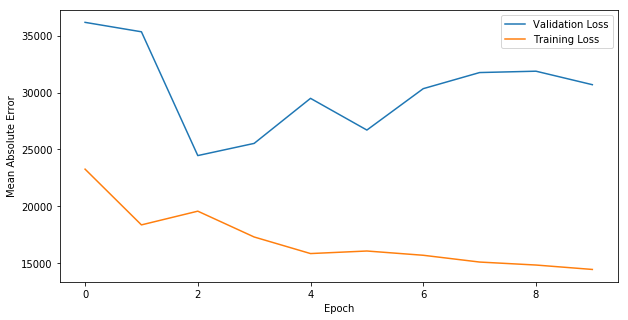

In [710]:
plt.figure(figsize=[10,5])
index = np.arange(0,len(train_history.history['val_loss']))

plt.plot(index,train_history.history['val_loss'])
plt.plot(index,train_history.history['loss'])
plt.legend(['Validation Loss', 'Training Loss'])
plt.ylabel("Mean Absolute Error")
plt.xlabel("Epoch")

plt.show()

In [711]:
model_id = random.randint(0,9999999)
path = "model/" + str(model_id)
os.mkdir(path)

file = open(path + "/model_parameters.txt","a") 
file.write("Type: {}\n".format("CNN + MLP")) 
file.write("CNN Dimensions {}-{}\n".format(cnn_kernels,cnn_dropout)) 
file.write("MLP Dimensions {}\n".format(mlp_layers)) 

file.write("Learning Rate: {}\n".format(learning_rate)) 
file.write("Epochs: {}\n".format(epochs)) 
file.write("Decay: {}\n".format(decay)) 
file.write("Batch Size: {}\n".format(batch_size)) 
file.write("Loss: {}\n".format(train_history.history['loss'])) 
file.write("Validation Loss: {}\n".format(train_history.history['val_loss']))
file.write("Final Validation Loss: {}".format(train_history.history['val_loss'][-1])) 

file.close() 


model.save(path+"/model_weights.hdf5")
model_json = model.to_json()
with open(path+"/model.json", "w") as json_file:
    json_file.write(model_json)


---

---

# Predict on Test Data

In [712]:
test_attrX_time = df_master.iloc[-1 * test_number_days::][testAttrX.columns]
test_imageX_time = df_master.iloc[-1 * test_number_days::][['Tag','NX_per_country_shifted']]
test_imageX_time = np.expand_dims(np.array(test_imageX_time['NX_per_country_shifted'].tolist()), axis=3)

In [713]:
preds = model.predict([test_attrX_time, test_imageX_time])

In [714]:
df_predictions = pd.DataFrame(columns=df.columns[2:12])
df_true_test_values = pd.DataFrame(columns=df.columns[2:12])

### Predictions

In [715]:
test_index = df_master.iloc[-1 * test_number_days::][['Tag']].reset_index(drop=True)
ind = 0 


for pred in preds:
    data = pd.DataFrame(data=pred,columns=df.columns[3:12])
    data['Tag'] = test_index['Tag'][ind] + np.arange(24) * datetime.timedelta(hours=1)

    if ind==0:
        df_predictions = data
    else:
        df_predictions = df_predictions.append(data)
    
    ind+=1

### Ground Truth

In [716]:
test_index = df_master.iloc[-1 * test_number_days::][['Tag']].reset_index(drop=True)
ind = 0 


for test in np.array(df_master.iloc[-1*test_number_days::]['NX_per_country'].tolist()):
    
    data = pd.DataFrame(data=test,columns=df.columns[3:12])
    
    data['Tag'] = test_index['Tag'][ind] + np.arange(24) * datetime.timedelta(hours=1)

    if ind==0:
        df_true_test_values = data
    else:
        df_true_test_values = df_true_test_values.append(data)
    
    ind+=1

---

## Compare Results

In [717]:
df_predictions = df_predictions.reset_index(drop=True)
df_true_test_values = df_true_test_values.reset_index(drop=True)

<Figure size 1440x720 with 0 Axes>

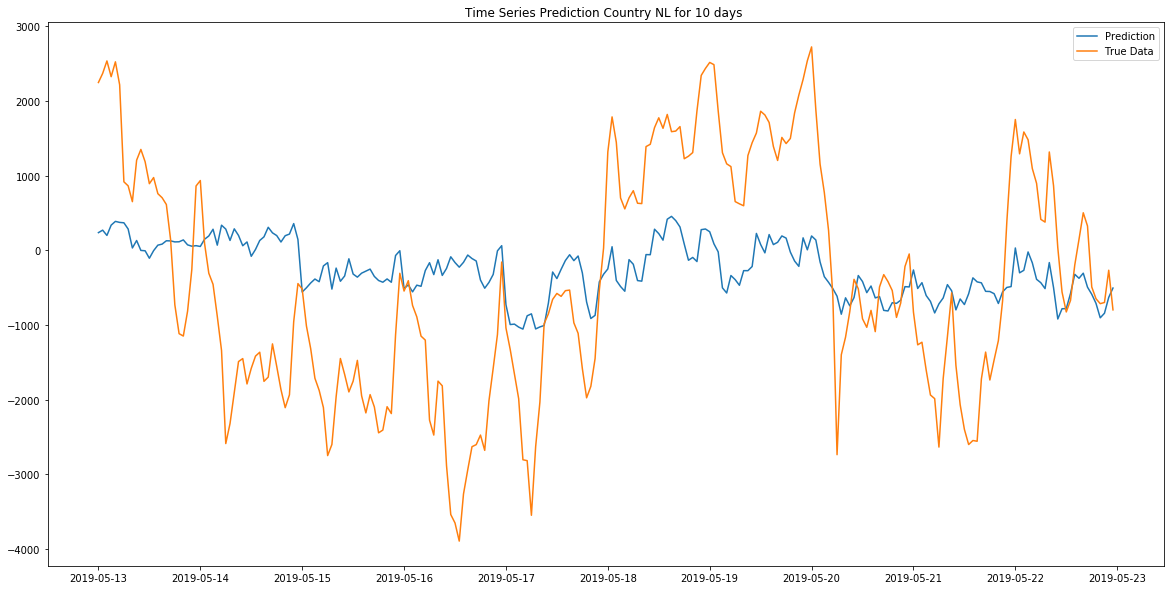

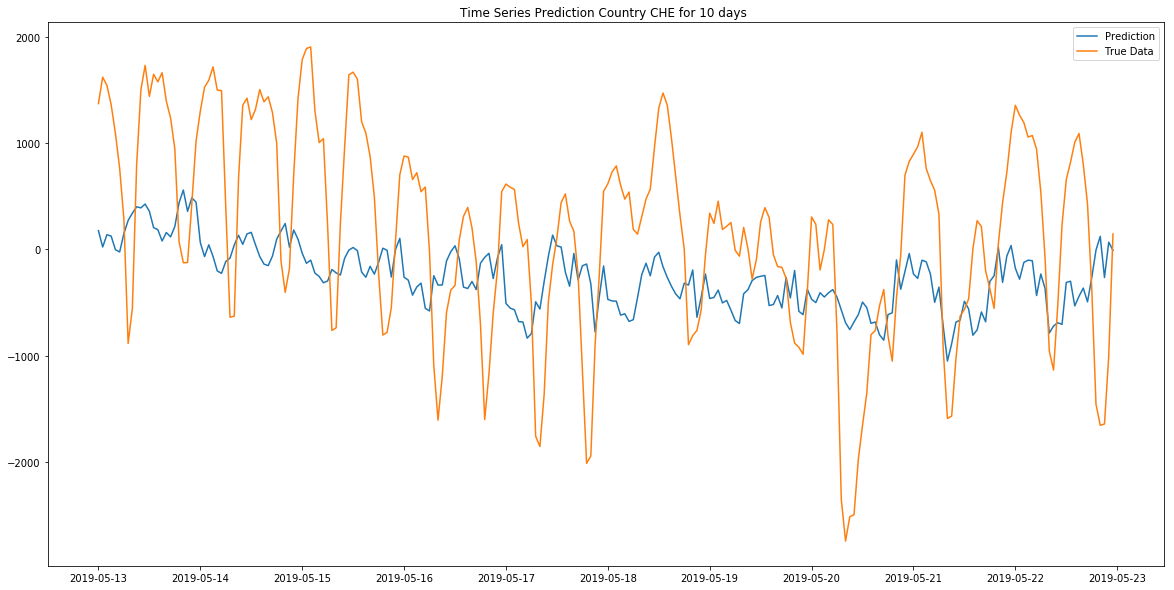

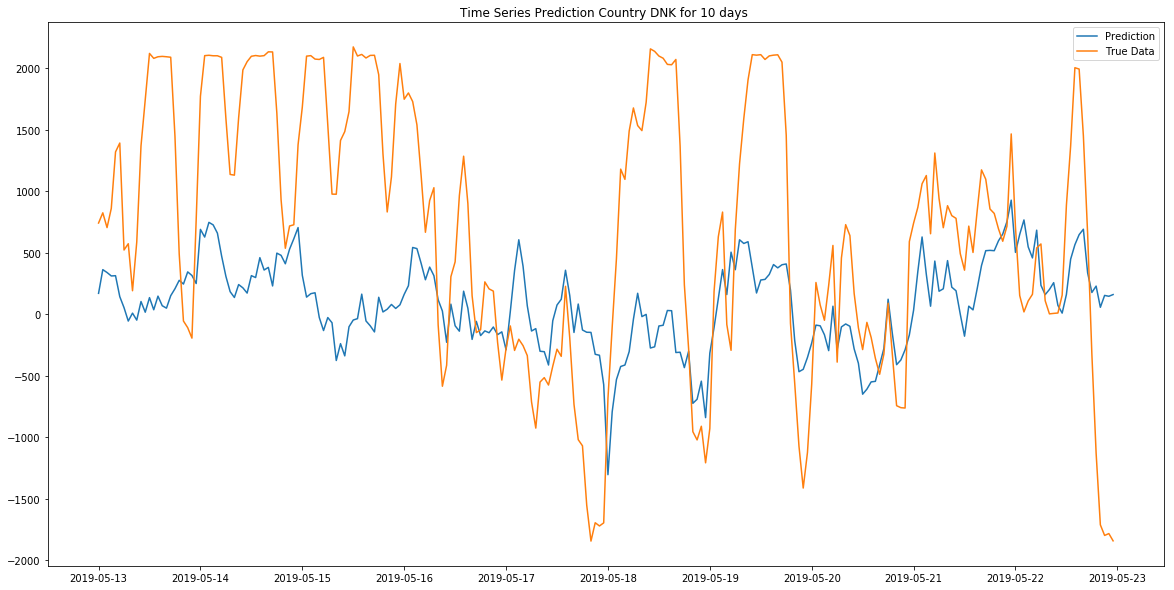

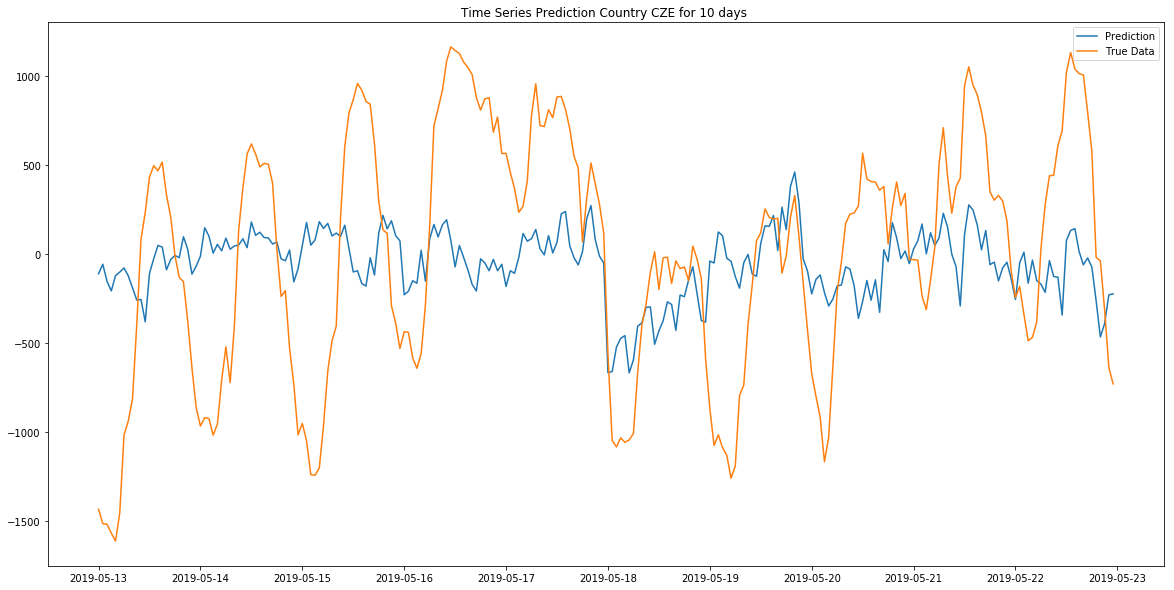

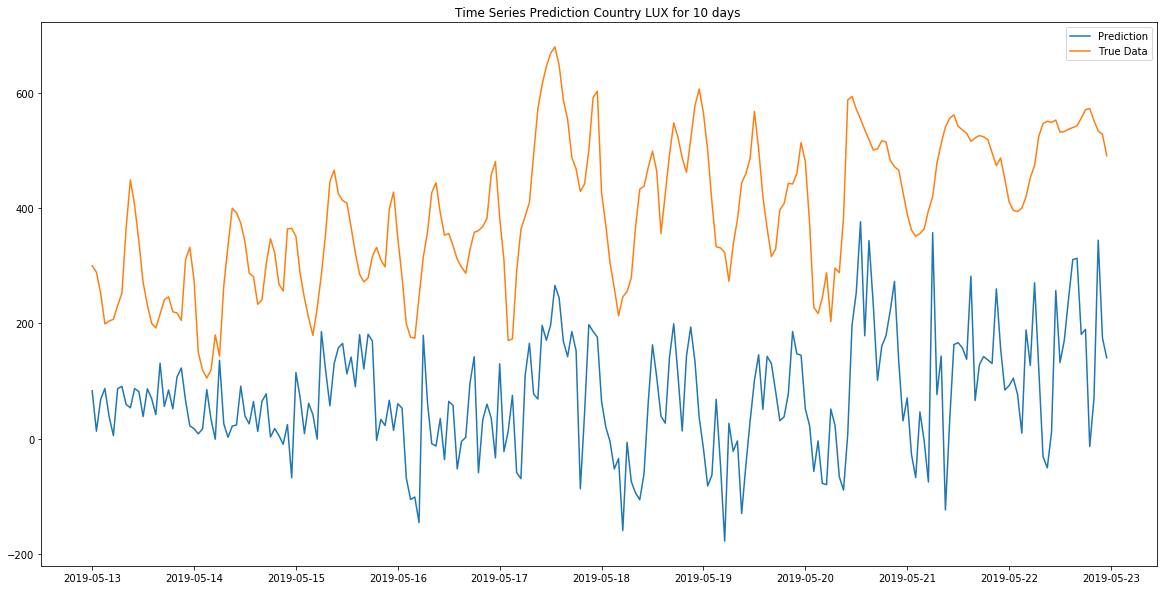

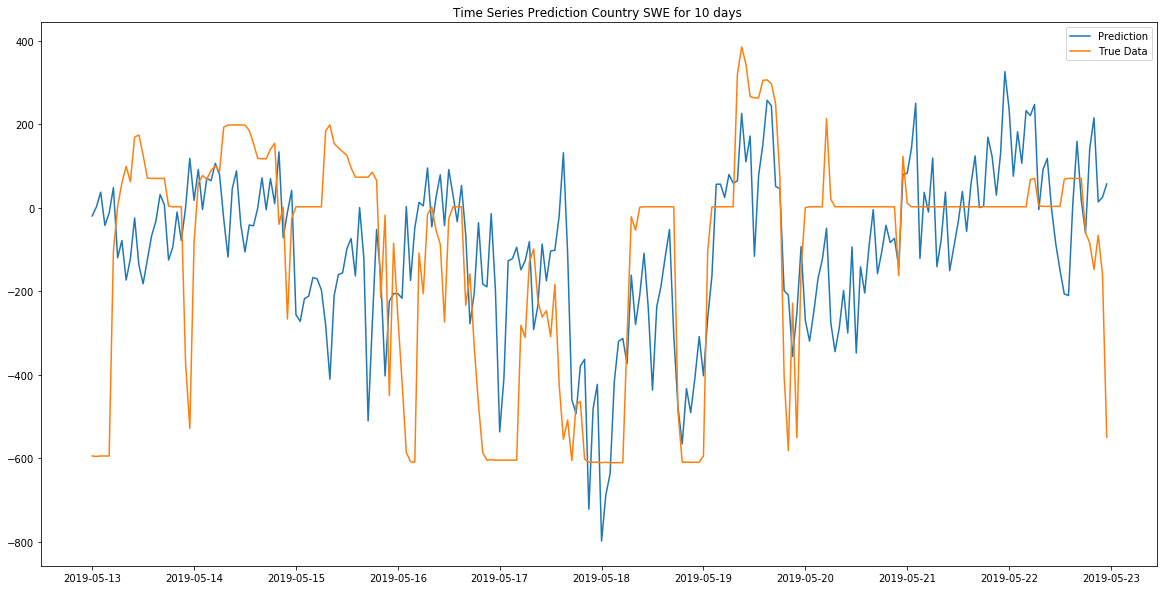

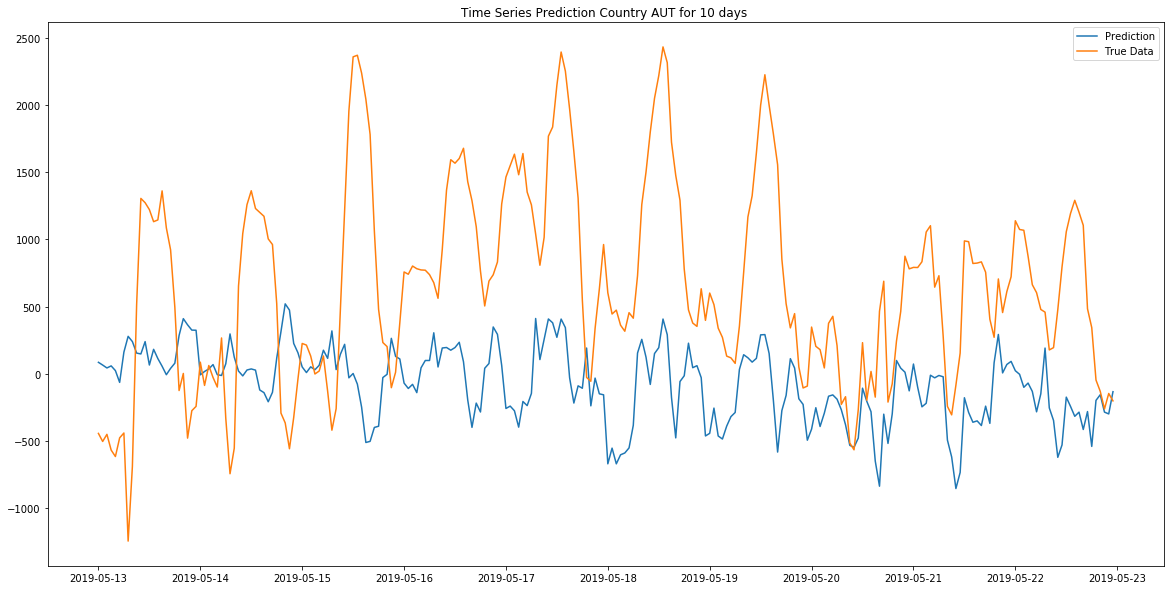

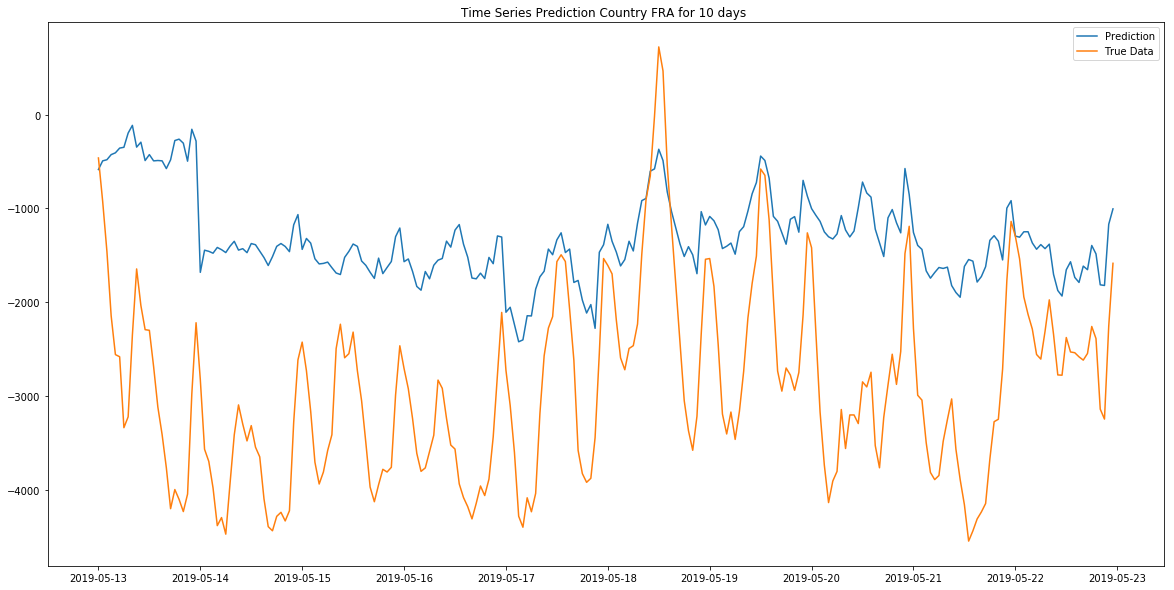

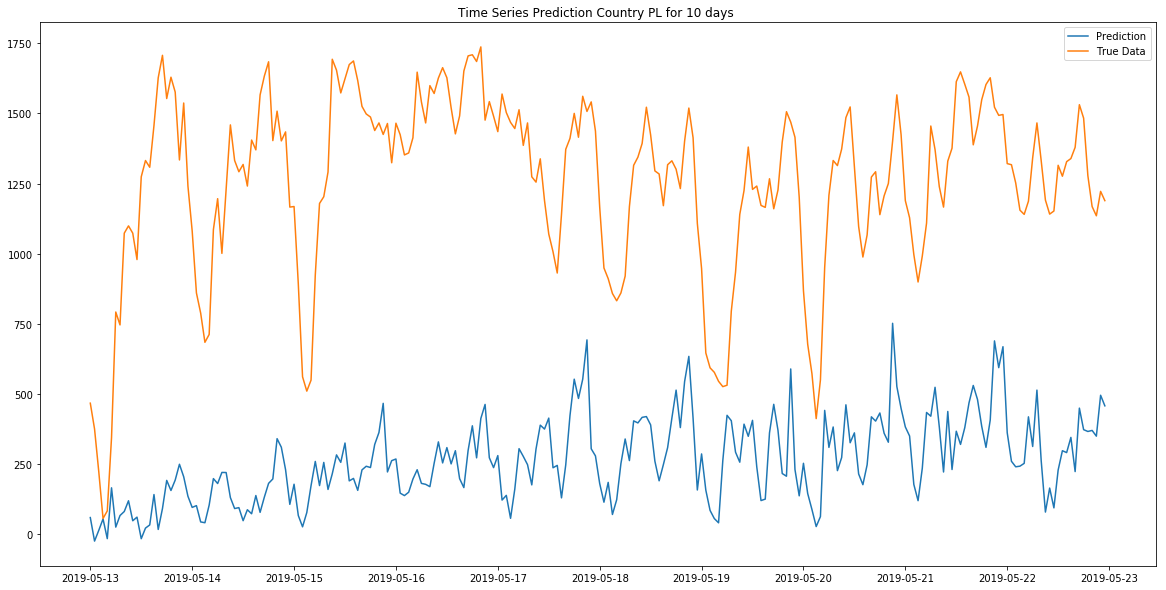

In [718]:
plt.figure(figsize=[20,10])

for col in df_predictions.columns[:9]:
    plt.figure(figsize=[20,10])
    plt.plot(df_predictions['Tag'],df_predictions[col])
    plt.plot(df_true_test_values['Tag'],df_true_test_values[col])
    plt.title("Time Series Prediction Country {} for {} days ".format(col,test_number_days))
    plt.legend(['Prediction','True Data'])
    plt.show()

---

In [663]:
weights = model.get_weights()
len(weights)

for ind in np.arange(0,len(weights)):
    print("Index {}: {}".format(ind,weights[ind].shape))

Index 0: (4, 1, 1, 16)
Index 1: (16,)
Index 2: (312, 1, 1, 16)
Index 3: (16,)
Index 4: (1, 1, 16, 1)
Index 5: (1,)
Index 6: (1, 1, 16, 1)
Index 7: (1,)
Index 8: (35, 64)
Index 9: (64,)
Index 10: (64, 256)
Index 11: (256,)
Index 12: (3505, 216)
Index 13: (216,)


In [680]:
weights[2][:,:,0,1]

array([[ 9.36188698e-01],
       [-1.33675754e-01],
       [-1.89259470e-01],
       [-1.62248120e-01],
       [-1.58515960e-01],
       [-1.56426802e-01],
       [-9.92527977e-02],
       [-2.91121881e-02],
       [-5.53180575e-02],
       [-1.12053499e-01],
       [-1.54999509e-01],
       [-4.71133031e-02],
       [-6.72548190e-02],
       [-8.57769325e-02],
       [-1.22646034e-01],
       [-6.28770888e-02],
       [ 1.28435949e-02],
       [ 8.84251893e-02],
       [ 3.90871204e-02],
       [ 1.01093665e-01],
       [ 1.54768214e-01],
       [ 9.64160711e-02],
       [ 1.31227538e-01],
       [ 1.16368699e+00],
       [ 9.06439647e-02],
       [-2.40238421e-02],
       [-1.20337889e-01],
       [-1.34510189e-01],
       [-1.08954869e-01],
       [-7.28202313e-02],
       [ 1.52789965e-01],
       [ 1.18686281e-01],
       [-5.49515104e-03],
       [ 1.90778740e-03],
       [-3.11297048e-02],
       [ 1.56565532e-02],
       [ 7.24976882e-02],
       [ 1.15640707e-01],
       [ 1.1